In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import casadi
import os
import sys
from matplotlib.ticker import FuncFormatter

## 1 - Forecasts

In [2]:
# Load [kWh]
load = [5.117, 5.117, 5.117, 5.117, 5.117, 5.117, 4.652, 4.652, 3.722, 3.722, 3.722, 3.722, 
        3.722, 3.257, 3.257, 3.257, 3.257, 3.257, 4.187, 4.187, 4.652, 4.652, 5.117, 5.117]

# To try variations
# load = [x/2 for x in load]

# Outside air temperature (°C)
T_OA = [12]*24

In [3]:
# Electricity prices [cts/kWh]
price_type = "peter"

if price_type == "gridworks":
    c_el = [6.36, 6.34, 6.34, 6.37, 6.41, 6.46, 6.95, 41.51,
            41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64,
            41.43, 41.51, 6.84, 6.65, 6.46, 6.4]

elif price_type == "progressive":
    c_el = [18.97, 18.92, 18.21, 16.58, 16.27, 15.49, 14.64,
            18.93, 45.56, 26.42, 18.0, 17.17, 16.19, 30.74, 31.17, 16.18,
            17.11, 20.24, 24.94, 24.69, 26.48, 30.15, 23.14, 24.11]

elif price_type == "peter":
    c_el = [0.07919, 0.066283, 0.063061, 0.067943, 0.080084, 0.115845, 
                0.193755, 0.215921, 0.110822, 0.044927, 0.01521, 0.00742, 
                0.004151, 0.007117, 0.009745, 0.02452, 0.037877, 0.09556, 
                0.205067, 0.282588, 0.234866, 0.184225, 0.132268, 0.101679]
    c_el = [x*100 for x in c_el]

## 2 - Estimating parameters from manufacturer data

In [4]:
B0_Q, B1_Q = -68851.589, 313.3151
B0_C, B1_C = 2.695868, -0.008533

def Q_HP_max(T_OA):
    T_OA += 273
    return round((B0_Q + B1_Q*T_OA)/1000,2) if T_OA<273-7 else 12
    
def COP1(T_OA):
    T_OA += 273
    return round(B0_C + B1_C*T_OA,2)

COP1_list = [COP1(temp) for temp in T_OA]

## 3 - Optimization problem (MILP)

In [5]:
def get_opti(N, c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list):

    # Initialize    
    #opti = casadi.Opti()
    opti = casadi.Opti('conic')
 
    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    storage = opti.variable(1,N+1)  # state
    Q_HP = opti.variable(1,N)       # input
    delta_HP = opti.variable(1,N)  # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # delta_HP is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete':discrete_var, 'gurobi.OutputFlag':0})
    #opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(storage[0] == storage_initial)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(storage[t] >= min_storage)
        opti.subject_to(storage[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(storage[t+1] == storage[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(delta_HP[t] >= 0)
            opti.subject_to(delta_HP[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= Q_HP_max_list[t])    
            opti.subject_to(Q_HP[t] >= Q_HP_min_list[t]*delta_HP[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= Q_HP_max_list[t]*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] >= Q_HP_min_list[t]*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + Q_HP_min_list[t]*(delta_HP[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + Q_HP_max_list[t]*(delta_HP[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*c_el[t]*COP1_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sys.stdout = open(os.devnull, 'w')
    sol = opti.solve()
    sys.stdout = sys.__stdout__

    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(storage)
    HP_on_off_opt = sol.value(delta_HP)
    obj_opt = round(sol.value(obj)/100,2)

    return Q_opt, stor_opt, HP_on_off_opt, obj_opt

## 6 - For different storage and heat pump sizes

In [6]:
# Horizon (hours)
N = 24

# The storage capacity (kWh)
min_storage = 0
storage_initial = 0

# Lifetime of equipement
lifetime_HP = 10
lifetime_TES = 10

def capex_HP(max_Q_HP):
    A = [5,8,12,16]
    C = [1984,2235,3257,3616]
    C = [x/365/lifetime_HP for x in C]
    C_polyfit = np.polyfit(A, C, 2)
    return(np.polyval(C_polyfit, max_Q_HP))

def capex_TES(max_storage):
    A = [6, 9, 12]
    C = [2416, 2857, 3297]
    C = [x/365/lifetime_TES for x in C]
    C_polyfit = np.polyfit(A, C, 2)
    return(np.polyval(C_polyfit, max_storage))

def get_TOTEX(max_storage, max_Q_HP):#, load):
    
    # The heat pump capacity (kW)
    min_Q_HP = 0.1*max_Q_HP
    Q_HP_max_list = [max_Q_HP]*N
    Q_HP_min_list = [min_Q_HP]*N
    
    # Get the optimal cost
    try:
        _, __, ___, obj_opt = get_opti(N, c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list)

        #print(f"Max stor: {max_storage} kWh, HP: {max_Q_HP} kWh")
        #print(f"OPEX: {round(obj_opt,2)}, CAPEX HP: {capex_HP(max_Q_HP)}, CAPEX TES: {capex_TES(max_storage)}")
        obj_opt += capex_HP(max_Q_HP)
        obj_opt += capex_TES(max_storage)
        #print(f"TOTEX = {round(obj_opt,2)}")
        
        return(obj_opt)
    except Exception as e:
        return np.nan

In [7]:
# Define the range of values for T_OA and T_sup_HP
storage_range = np.linspace(2, 35, 15)
heatpump_range = np.linspace(2, 40, 15)

# Generate a grid of T_OA and T_sup_HP values
storage_grid, heatpump_grid = np.meshgrid(storage_range, heatpump_range)

# Calculate the Q_max for each combination of T_OA and T_sup_HP
load = [5]*24
cost_values = np.vectorize(get_TOTEX)(storage_grid, heatpump_grid)
load = [10]*24
cost_values2 = np.vectorize(get_TOTEX)(storage_grid, heatpump_grid)
load = [20]*24
cost_values3 = np.vectorize(get_TOTEX)(storage_grid, heatpump_grid)

Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


76) -> -1
 (43, 76) -> 1
 (44, 76) -> -1
 (47, 77) -> -1
 (52, 77) -> 1
 (53, 77) -> -1
 (54, 77) -> 1
 (55, 77) -> -1
 (58, 78) -> -1
 (63, 78) -> 1
 (64, 78) -> -1
 (65, 78) -> 1
 (66, 78) -> -1
 (69, 79) -> -1
 (74, 79) -> 1
 (75, 79) -> -1
 (76, 79) -> 1
 (77, 79) -> -1
 (80, 80) -> -1
 (85, 80) -> 1
 (86, 80) -> -1
 (87, 80) -> 1
 (88, 80) -> -1
 (91, 81) -> -1
 (96, 81) -> 1
 (97, 81) -> -1
 (98, 81) -> 1
 (99, 81) -> -1
 (102, 82) -> -1
 (107, 82) -> 1
 (108, 82) -> -1
 (109, 82) -> 1
 (110, 82) -> -1
 (113, 83) -> -1
 (118, 83) -> 1
 (119, 83) -> -1
 (120, 83) -> 1
 (121, 83) -> -1
 (124, 84) -> -1
 (129, 84) -> 1
 (130, 84) -> -1
 (131, 84) -> 1
 (132, 84) -> -1
 (135, 85) -> -1
 (140, 85) -> 1
 (141, 85) -> -1
 (142, 85) -> 1
 (143, 85) -> -1
 (146, 86) -> -1
 (151, 86) -> 1
 (152, 86) -> -1
 (153, 86) -> 1
 (154, 86) -> -1
 (157, 87) -> -1
 (162, 87) -> 1
 (163, 87) -> -1
 (164, 87) -> 1
 (165, 87) -> -1
 (168, 88) -> -1
 (173, 88) -> 1
 (174, 88) -> -1
 (175, 88) -> 1
 (176

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c97600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (12

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.2
 (8, 49) -> -2
 (9, 49) -> 0.2
 (10, 49) -> -0.2
 (11, 49) -> 2
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 0.2
 (19, 50) -> -2
 (20, 50) -> 0.2
 (21, 50) -> -0.2
 (22, 50) -> 2
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 0.2
 (30, 51) -> -2
 (31, 51) -> 0.2
 (32, 51) -> -0.2
 (33, 51) -> 2
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 0.2
 (41, 52) -> -2
 (42, 52) -> 0.2
 (43, 52) -> -0.2
 (44, 52) -> 2
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 0.2
 (52, 53) -> -2
 (53, 53) -> 0.2
 (54, 53) -> -0.2
 (55, 53) -> 2
 (59, 54) -> -1
 (60, 54) -> 1
 (62, 54) -> 0.2
 (63, 54) -> -2
 (64, 54) -> 0.2
 (65, 54) -> -0.2
 (66, 54) -> 2
 (70, 55) -> -1
 (71, 55

Academic license - for non-commercial use only
Academic license - for non-commercial use only


42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.2
 (8, 49) -> -2
 (9, 49) -> 0.2
 (10, 49) -> -0.2
 (11, 49) -> 2
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 0.2
 (19, 50) -> -2
 (20, 50) -> 0.2
 (21, 50) -> -0.2
 (22, 50) -> 2
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 0.2
 (30, 51) -> -2
 (31, 51) -> 0.2
 (32, 51) -> -0.2
 (33, 51) -> 2
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 0.2
 (41, 52) -> -2
 (42, 52) -> 0.2
 (43, 52) -> -0.2
 (44, 52) -> 2
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 0.2
 (52, 53) -> -2
 (53, 53) -> 0.2
 (54, 53) -> -0.2
 (55, 53) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (2

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f737d200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7457200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157,

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c9c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71da000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7464a00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71db600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ee00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f745cc00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f829a000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7458000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (2

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c36000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c74400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

Function solver_qpsol (0x7f89f71da000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ba00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


-1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.2
 (8, 49) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c48c00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f80f2200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ca00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c51400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c9c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (2

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8ca1c00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.471429
 (8, 49) -> -4.71429
 (9, 49) -> 0.471429
 (10, 49) -> -0.471429
 (11, 49) -> 4.71429
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 0.471429
 (19, 50) -> -4.71429
 (20, 50) -> 0.471429
 (21, 50) -> -0.471429
 (22, 50) -> 4.71429
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 0.471429
 (30, 51) -> -4.71429
 (31, 51) -> 0.471429
 (32, 51) -> -0.471429
 (33, 51) -> 4.71429
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 0.471429
 (41, 52) -> -4.71429
 (42, 52) -> 0.471429
 (43, 52) -> -0.471429
 (44, 52) -> 4.71429
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 0.471429
 (52, 53) -> -4.71429
 (53, 53) -> 0.471429
 (54, 53) -> -0.471429
 (55, 53) -> 4.71429
 (59, 54) -> -1
 (60, 54) -> 1
 (62, 54) -> 0.471429
 (63, 54) -> -4.71429
 (64, 54) -> 0.471429
 (65, 54) -> -0.471429
 (66, 54) -> 4.71429
 (70, 55) -> -1
 (71, 55) -> 1
 (73, 55) -> 0.471429
 (74, 55) -> -4.71429
 (75, 55) -> 0.471429
 (76, 55) -> -0.471429
 (77, 55) -> 4.

Academic license - for non-commercial use only
Academic license - for non-commercial use only


sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c9c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only



Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c49600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c51400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ee00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4aa00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c97600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.742857
 (8, 49) -> -7.42857
 (9, 49) -> 0.742857
 (10, 49) -> -0.742857
 (11, 49) -> 7.42857
 (15, 50) -> -1
 (16, 50

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71da000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91,

Academic license - for non-commercial use only
Academic license - for non-commercial use only


26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7463200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c49600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71da600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4aa00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (4

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f827f400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.742857
 (8, 49) -> -7.42857
 (9, 49) -> 0.742857
 (10, 49) -> -0.742857
 (11, 49) -> 7.42857
 (15, 50) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f80f0400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71db200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

Function solver_qpsol (0x7f89f7c4c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1


Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c36000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7463200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c4d800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f743b000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.2
 (8, 49) -> -2
 (9, 49) -> 0.2
 (10, 49) -> -0.2
 (11, 49) -> 2
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 0.2
 (19, 50) -> -2
 (20, 50) -> 0.2
 (21, 50) -> -0.2
 (22, 50) -> 2
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 0.2
 (30, 51) -> -2
 (31, 51) -> 0.2
 (32, 51) -> -0.2
 (33, 51) -> 2
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 0.2
 (41, 52) -> -2
 (42, 52) -> 0.2
 (43, 52) -> -0.2
 (44, 52) -> 2
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 0.2
 (52, 53) -> -2
 (53, 53) -> 0.2
 (54, 53) -> -0.2
 (55, 53) -> 2
 (59, 54) -> -1
 (60, 54) -> 1
 (62, 54) -> 0.2
 (63, 54) -> -2
 (64, 54) -> 0.2
 (65, 54) -> -0.2
 (66, 54) -> 2
 (70, 55) -> -1
 (71, 55) -> 1
 (73, 55) -> 0.2
 (74, 55

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c46400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1


Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c51400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (0x7f89f71d9000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> -4.71429
 (75, 55) -> 0.471429
 (76, 55) -> -0.471429
 (77, 55) -> 4.71429
 (81, 56) -> -1
 (82, 56) -> 1
 (84, 56) -> 0.471429
 (85, 56) -> -4.71429
 (86, 56) -> 0.471429
 (87, 56) -> -0.471429
 (88, 56) -> 4.71429
 (92, 57) -> -1
 (93, 57) -> 1
 (95, 57) -> 0.471429
 (96, 57) -> -4.71429
 (97, 57) -> 0.471429
 (98, 57) -> -0.471429
 (99, 57) -> 4.71429
 (103, 58) -> -1
 (104, 58) -> 1
 (106, 58) -> 0.471429
 (107, 58) -> -4.71429
 (108, 58) -> 0.471429
 (109, 58) -> -0.471429
 (110, 58) -> 4.71429
 (114, 59) -> -1
 (115, 59) -> 1
 (117, 59) -> 0.471429
 (118, 59) -> -4.71429
 (119, 59) -> 0.471429
 (120, 59) -> -0.471429
 (121, 59) -> 4.71429
 (125, 60) -> -1
 (126, 60) -> 1
 (128, 60) -> 0.471429
 (129, 60) -> -4.71429
 (130, 60) -> 0.471429
 (131, 60) -> -0.471429
 (132, 60) -> 4.71429
 (136, 61) -> -1
 (137, 61) -> 1
 (139, 61) -> 0.471429
 (140, 61) -> -4.71429
 (141, 61) -> 0.471429
 (142, 61) -> -0.471429
 (143, 61) -> 4.71429
 (147, 62) -> -1
 (148, 62) -> 1
 (150, 62) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (15

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c51400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c50e00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f745d600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7458800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c5e400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7457400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c5a800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4e400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f743b000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (24

Academic license - for non-commercial use only
Academic license - for non-commercial use only


19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117,

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8924e00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7,

Academic license - for non-commercial use only
Academic license - for non-commercial use only


48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 0.742857
 (8, 49) -> -7.42857
 (9, 49) -> 0.742857
 (10, 49) -> -0.742857
 (11, 49) -> 7.42857
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 0.742857
 (19, 50) -> -7.42857
 (20, 50) -> 0.742857
 (21, 50) -> -0.742857
 (22, 50) -> 7.42857
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 0.742857
 (30, 51) -> -7.42857
 (31, 51) -> 0.742857
 (32, 51) -> -0.742857
 (33, 51) -> 7.42857
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 0.742857
 (41, 52) -> -7.42857
 (42, 52) -> 0.742857
 (43, 52) -> -0.742857
 (44, 52) -> 7.42857
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 0.742857
 (52, 53) -> -7.42857
 (53, 53) -> 0.742857
 (54, 53) -> -0.742857
 (55, 53) -> 7.42857
 (59, 54) -> -1
 (60, 54) -> 1
 (62, 54) -> 0.742857
 (63, 54) -> -7.42857
 (64, 54) -> 0.742857
 (65, 54) -> -0.742857
 (66, 54) -> 7.42857
 (70, 55) -> -1
 (71, 55) -> 1
 (73, 55) -> 0.742857
 (74, 55) -> -7.42857
 (75, 55) -> 0.742857
 (76, 55) -> -0.742857
 (77, 55) -> 7.42857
 (81, 56)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c49600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71db000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ca00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c65c00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c9c400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c51400)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c69800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 54) -> 1.01429
 (65, 54) -> -1.01429
 (66, 54) -> 10.1429
 (70, 55) -> -1
 (71, 55) -> 1
 (73, 55) -> 1.01429
 (74, 55) -> -10.1429
 (75, 55) -> 1.01429
 (76, 55) -> -1.01429
 (77, 55) -> 10.1429
 (81, 56) -> -1
 (82, 56) -> 1
 (84, 56) -> 1.01429
 (85, 56) -> -10.1429
 (86, 56) -> 1.01429
 (87, 56) -> -1.01429
 (88, 56) -> 10.1429
 (92, 57) -> -1
 (93, 57) -> 1
 (95, 57) -> 1.01429
 (96, 57) -> -10.1429
 (97, 57) -> 1.01429
 (98, 57) -> -1.01429
 (99, 57) -> 10.1429
 (103, 58) -> -1
 (104, 58) -> 1
 (106, 58) -> 1.01429
 (107, 58) -> -10.1429
 (108, 58) -> 1.01429
 (109, 58) -> -1.01429
 (110, 58) -> 10.1429
 (114, 59) -> -1
 (115, 59) -> 1
 (117, 59) -> 1.01429
 (118, 59) -> -10.1429
 (119, 59) -> 1.01429
 (120, 59) -> -1.01429
 (121, 59) -> 10.1429
 (125, 60) -> -1
 (126, 60) -> 1
 (128, 60) -> 1.01429
 (129, 60) -> -10.1429
 (130, 60) -> 1.01429
 (131, 60) -> -1.01429
 (132, 60) -> 10.1429
 (136, 61) -> -1
 (137, 61) -> 1
 (139, 61) -> 1.01429
 (140, 61) -> -10.1429
 (141, 61) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71db200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


-1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c4d800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.28571
 (8, 49) -> -12.8571
 (9, 49) -> 1.28571
 (10, 49) -> -1.28571
 (11, 49) -> 12.8571
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 1.28571
 (19, 50) -> -12.8571
 (20, 50) -> 1.28571
 (21, 50) -> -1.28571
 (22, 50) -> 12.8571
 (26, 51) -> -1
 (27, 51) -> 1
 (29

Academic license - for non-commercial use only
Academic license - for non-commercial use only


-1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (

Academic license - for non-commercial use only
Academic license - for non-commercial use only


209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.28571
 (8, 49) -> -12.8571
 (9, 49) -> 1.28571
 (10, 49) -> -1.28571
 (11, 49) -> 12.8571
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 1.28571
 (19, 50) -> -12.8571
 (20, 50) -> 1.28571
 (21, 50) -> -1.28571
 (22, 50) -> 12.8571
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 1.28571
 (30, 51) -> -12.8571
 (31, 51) -> 1.28571
 (32, 51) -> -1.28571
 (33, 51) -> 12.8571
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 1.28571
 (41, 52) -> -12.8571
 (42, 52) -> 1.28571
 (43, 52) -> -1.28571
 (44, 52) -> 12.8571
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 1.28571
 (52, 53) -> -12.8571
 (53, 53) -> 1.28571
 (54, 53) -> -

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.28571
 (8, 49) -> -12.8571
 (9, 49) -> 1.28571
 (10, 49) -> -1.28571
 (11, 49) -> 12.8571
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 1.28571
 (19, 50) -> -12.8571
 (20, 50) -> 1.28571
 (21, 50) -> -1.28571
 (22, 50) -> 12.8571
 (26, 51) -> -1
 (27,

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.28571
 (8, 49) -> -12.8571
 (9, 49) -> 1.28571
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f71d9000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f737dc00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 56) -> 1.28571
 (87, 56) -> -1.28571
 (88, 56) -> 12.8571
 (92, 57) -> -1
 (93, 57) -> 1
 (95, 57) -> 1.28571
 (96, 57) -> -12.8571
 (97, 57) -> 1.28571
 (98, 57) -> -1.28571
 (99, 57) -> 12.8571
 (103, 58) -> -1
 (104, 58) -> 1
 (106, 58) -> 1.28571
 (107, 58) -> -12.8571
 (108, 58) -> 1.28571
 (109, 58) -> -1.28571
 (110, 58) -> 12.8571
 (114, 59) -> -1
 (115, 59) -> 1
 (117, 59) -> 1.28571
 (118, 59) -> -12.8571
 (119, 59) -> 1.28571
 (120, 59) -> -1.28571
 (121, 59) -> 12.8571
 (125, 60) -> -1
 (126, 60) -> 1
 (128, 60) -> 1.28571
 (129, 60) -> -12.8571
 (130, 60) -> 1.28571
 (131, 60) -> -1.28571
 (132, 60) -> 12.8571
 (136, 61) -> -1
 (137, 61) -> 1
 (139, 61) -> 1.28571
 (140, 61) -> -12.8571
 (141, 61) -> 1.28571
 (142, 61) -> -1.28571
 (143, 61) -> 12.8571
 (147, 62) -> -1
 (148, 62) -> 1
 (150, 62) -> 1.28571
 (151, 62) -> -12.8571
 (152, 62) -> 1.28571
 (153, 62) -> -1.28571
 (154, 62) -> 12.8571
 (158, 63) -> -1
 (159, 63) -> 1
 (161, 63) -> 1.28571
 (162, 63) -> -12.8571

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) -> -1
 (164, 39) -> -1
 (165, 39) -> 1
 (171, 40) -> 1
 (172, 40) -> -1
 (175, 40) -> -1
 (176, 40) -> 1
 (182, 41) -> 1
 (183, 41) -> -1
 (186, 41) -> -1
 (187, 41) -> 1
 (193, 42) -> 1
 (194, 42) -> -1
 (197, 42) -> -1
 (198, 42) -> 1
 (204, 43) -> 1
 (205, 43) -> -1
 (208, 43) -> -1
 (209, 43) -> 1
 (215, 44) -> 1
 (216, 44) -> -1
 (219, 44) -> -1
 (220, 44) -> 1
 (226, 45) -> 1
 (227, 45) -> -1
 (230, 45) -> -1
 (231, 45) -> 1
 (237, 46) -> 1
 (238, 46) -> -1
 (241, 46) -> -1
 (242, 46) -> 1
 (248, 47) -> 1
 (249, 47) -> -1
 (252, 47) -> -1
 (253, 47) -> 1
 (259, 48) -> 1
 (260, 48) -> -1
 (263, 48) -> -1
 (264, 48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.28571
 (8, 49) -> -12.8571
 (9, 49) -> 1.28571
 (10, 49) -> -1.28571
 (11, 49) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8926200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4aa00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f737e200)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ee00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7ca4000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7467000)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (10

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f745b800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


-1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 32) -> -1
 (87, 32) -> -1
 (88, 32) -> 1
 (94, 33) -> 1
 (95, 33) -> -1
 (98, 33) -> -1
 (99, 33) -> 1
 (105, 34) -> 1
 (106, 34) -> -1
 (109, 34) -> -1
 (110, 34) -> 1
 (116, 35) -> 1
 (117, 35) -> -1
 (120, 35) -> -1
 (121, 35) -> 1
 (127, 36) -> 1
 (128, 36) -> -1
 (131, 36) -> -1
 (132, 36) -> 1
 (138, 37) -> 1
 (139, 37) -> -1
 (142, 37) -> -1
 (143, 37) -> 1
 (149, 38) -> 1
 (150, 38) -> -1
 (153, 38) -> -1
 (154, 38) -> 1
 (160, 39) -> 1
 (161, 39) ->

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8ca1600)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


48) -> 1
 (4, 49) -> -1
 (5, 49) -> 1
 (7, 49) -> 1.82857
 (8, 49) -> -18.2857
 (9, 49) -> 1.82857
 (10, 49) -> -1.82857
 (11, 49) -> 18.2857
 (15, 50) -> -1
 (16, 50) -> 1
 (18, 50) -> 1.82857
 (19, 50) -> -18.2857
 (20, 50) -> 1.82857
 (21, 50) -> -1.82857
 (22, 50) -> 18.2857
 (26, 51) -> -1
 (27, 51) -> 1
 (29, 51) -> 1.82857
 (30, 51) -> -18.2857
 (31, 51) -> 1.82857
 (32, 51) -> -1.82857
 (33, 51) -> 18.2857
 (37, 52) -> -1
 (38, 52) -> 1
 (40, 52) -> 1.82857
 (41, 52) -> -18.2857
 (42, 52) -> 1.82857
 (43, 52) -> -1.82857
 (44, 52) -> 18.2857
 (48, 53) -> -1
 (49, 53) -> 1
 (51, 53) -> 1.82857
 (52, 53) -> -18.2857
 (53, 53) -> 1.82857
 (54, 53) -> -1.82857
 (55, 53) -> 18.2857
 (59, 54) -> -1
 (60, 54) -> 1
 (62, 54) -> 1.82857
 (63, 54) -> -18.2857
 (64, 54) -> 1.82857
 (65, 54) -> -1.82857
 (66, 54) -> 18.2857
 (70, 55) -> -1
 (71, 55) -> 1
 (73, 55) -> 1.82857
 (74, 55) -> -18.2857
 (75, 55) -> 1.82857
 (76, 55) -> -1.82857
 (77, 55) -> 18.2857
 (81, 56) -> -1
 (82, 56) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4aa00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only



 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28

Academic license - for non-commercial use only
Academic license - for non-commercial use only


, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4ca00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 1
 (177, 16) -> -1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (23

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c6cc00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


solver_qpsol (0x7f89f8c4d800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -

Academic license - for non-commercial use only
Academic license - for non-commercial use only


97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 (79, 7) -> 1
 (80, 7) -> -1
 (80, 8) -> 1
 (89, 8) -> -1
 (90, 8) -> 1
 (91, 8) -> -1
 (91, 9) -> 1
 (100, 9) -> -1
 (101, 9) -> 1
 (102, 9) -> -1
 (102, 10) -> 1
 (111, 10) -> -1
 (112, 10) -> 1
 (113, 10) -> -1
 (113, 11) -> 1
 (122, 11) -> -1
 (123, 11) -> 1
 (124, 11) -> -1
 (124, 12) -> 1
 (133, 12) -> -1
 (134, 12) -> 1
 (135, 12) -> -1
 (135, 13) -> 1
 (144, 13) -> -1
 (145, 13) -> 1
 (146, 13) -> -1
 (146, 14) -> 1
 (155, 14) -> -1
 (156, 14) -> 1
 (157, 14) -> -1
 (157, 15) -> 1
 (166, 15) -> -1
 (167, 15) -> 1
 (168, 15) -> -1
 (168, 16) -> 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c5ae00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c36800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f7c4aa00)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


Function solver_qpsol (0x7f89f8c4d800)
Input 0 (h): all zero sparse: 97-by-97
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.05894, 1.72336, 1.63959, 1.76652, 2.08218, 3.01197, 5.03763, 5.61395, 2.88137, 1.1681, 0.39546, 0.19292, 0.107926, 0.185042, 0.25337, 0.63752, 0.984802, 2.48456, 5.33174, 7.34729, 6.10652, 4.78985, 3.43897, 2.64365]
Input 2 (a): sparse: 267-by-97, 483 nnz
 (0, 0) -> 1
 (1, 0) -> -1
 (2, 0) -> 1
 (3, 0) -> -1
 (3, 1) -> 1
 (12, 1) -> -1
 (13, 1) -> 1
 (14, 1) -> -1
 (14, 2) -> 1
 (23, 2) -> -1
 (24, 2) -> 1
 (25, 2) -> -1
 (25, 3) -> 1
 (34, 3) -> -1
 (35, 3) -> 1
 (36, 3) -> -1
 (36, 4) -> 1
 (45, 4) -> -1
 (46, 4) -> 1
 (47, 4) -> -1
 (47, 5) -> 1
 (56, 5) -> -1
 (57, 5) -> 1
 (58, 5) -> -1
 (58, 6) -> 1
 (67, 6) -> -1
 (68, 6) -> 1
 (69, 6) -> -1
 (69, 7) -> 1
 (78, 7) -> -1
 

Academic license - for non-commercial use only
Academic license - for non-commercial use only


-1
 (178, 16) -> 1
 (179, 16) -> -1
 (179, 17) -> 1
 (188, 17) -> -1
 (189, 17) -> 1
 (190, 17) -> -1
 (190, 18) -> 1
 (199, 18) -> -1
 (200, 18) -> 1
 (201, 18) -> -1
 (201, 19) -> 1
 (210, 19) -> -1
 (211, 19) -> 1
 (212, 19) -> -1
 (212, 20) -> 1
 (221, 20) -> -1
 (222, 20) -> 1
 (223, 20) -> -1
 (223, 21) -> 1
 (232, 21) -> -1
 (233, 21) -> 1
 (234, 21) -> -1
 (234, 22) -> 1
 (243, 22) -> -1
 (244, 22) -> 1
 (245, 22) -> -1
 (245, 23) -> 1
 (254, 23) -> -1
 (255, 23) -> 1
 (256, 23) -> -1
 (256, 24) -> 1
 (265, 24) -> -1
 (266, 24) -> 1
 (6, 25) -> 1
 (7, 25) -> -1
 (10, 25) -> -1
 (11, 25) -> 1
 (17, 26) -> 1
 (18, 26) -> -1
 (21, 26) -> -1
 (22, 26) -> 1
 (28, 27) -> 1
 (29, 27) -> -1
 (32, 27) -> -1
 (33, 27) -> 1
 (39, 28) -> 1
 (40, 28) -> -1
 (43, 28) -> -1
 (44, 28) -> 1
 (50, 29) -> 1
 (51, 29) -> -1
 (54, 29) -> -1
 (55, 29) -> 1
 (61, 30) -> 1
 (62, 30) -> -1
 (65, 30) -> -1
 (66, 30) -> 1
 (72, 31) -> 1
 (73, 31) -> -1
 (76, 31) -> -1
 (77, 31) -> 1
 (83, 32) -> 1
 (84, 

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

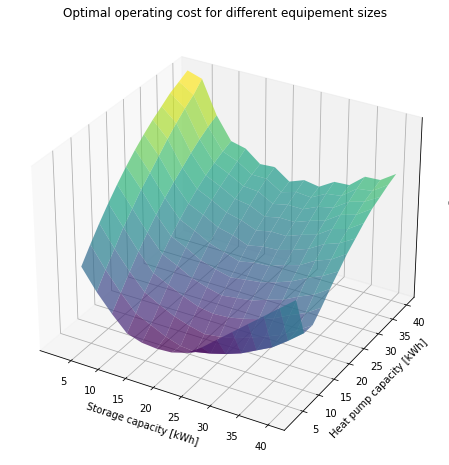

In [8]:
# Create a 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

# Plot the surface
surface = ax.plot_surface(storage_grid, heatpump_grid, cost_values, cmap='viridis', alpha=0.7)
#surface2 = ax.plot_surface(storage_grid, heatpump_grid, cost_values2, cmap='coolwarm', alpha=0.7)
#surface3 = ax.plot_surface(storage_grid, heatpump_grid, cost_values3, cmap='plasma', alpha=0.7)

# Add labels and title
ax.set_xlabel('Storage capacity [kWh]')
ax.set_ylabel('Heat pump capacity [kWh]')
ax.set_zlabel('Cost')
ax.set_zticks([])
ax.set_title('Optimal operating cost for different equipement sizes')

# Show the plot
plt.show()

In [9]:
'''
# rows: heat pump capacity
# cols: storage capacity

num_hp = len(cost_values[:][0])
num_stor = len(cost_values[0])

# Iterate over indices and assign colors based on non-np.nan values
for i in range(num_hp):
    for j in range(num_stor):
        
        # First load
        if not np.isnan(cost_values[i][j]):
            cost_values[i][j] = 1
        else:
            cost_values[i][j] = np.nan

        # Second load
        if not np.isnan(cost_values2[i][j]):
            cost_values2[i][j] = 1
        else:
            cost_values2[i][j] = np.nan

# Plot filled area
plt.pcolormesh(np.transpose(cost_values), cmap='viridis', edgecolors='none',alpha=0.3)
plt.pcolormesh(np.transpose(cost_values2), cmap='coolwarm', edgecolors='none',alpha=0.3)
#plt.pcolormesh(np.transpose(cost_values3), cmap='viridis', edgecolors='none',alpha=0.3)

# Set labels and title
plt.xlabel('Heat pump capacity (kW)')
plt.ylabel('Storage capacity (kWh)')
plt.title('Feasible area')

# Get current xticks and multiply each by 2
xticks = list(range(num_hp))
modified_xticks = [round(heatpump_range[int(x-1)]) if x>0 else 0 for x in xticks]
yticks = list(range(num_stor))
modified_yticks = [round(storage_range[int(x-1)]) if x>0 else 0 for x in yticks]

# Set the modified xticks back to the plot
plt.xticks(xticks, modified_xticks)
plt.yticks(yticks, modified_yticks)

plt.xlim([-0.5,num_hp+0.5])
plt.ylim([-0.5,num_stor+0.5])

plt.show()
'''

"\n# rows: heat pump capacity\n#\xa0cols: storage capacity\n\nnum_hp = len(cost_values[:][0])\nnum_stor = len(cost_values[0])\n\n# Iterate over indices and assign colors based on non-np.nan values\nfor i in range(num_hp):\n    for j in range(num_stor):\n        \n        # First load\n        if not np.isnan(cost_values[i][j]):\n            cost_values[i][j] = 1\n        else:\n            cost_values[i][j] = np.nan\n\n        #\xa0Second load\n        if not np.isnan(cost_values2[i][j]):\n            cost_values2[i][j] = 1\n        else:\n            cost_values2[i][j] = np.nan\n\n# Plot filled area\nplt.pcolormesh(np.transpose(cost_values), cmap='viridis', edgecolors='none',alpha=0.3)\nplt.pcolormesh(np.transpose(cost_values2), cmap='coolwarm', edgecolors='none',alpha=0.3)\n#plt.pcolormesh(np.transpose(cost_values3), cmap='viridis', edgecolors='none',alpha=0.3)\n\n# Set labels and title\nplt.xlabel('Heat pump capacity (kW)')\nplt.ylabel('Storage capacity (kWh)')\nplt.title('Feasible 